cifar100-classifier

In [2]:
#引包
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import os
from scipy import misc
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import pickle
import numpy as np

In [3]:
#文件打开函数
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

先查看meta，顺便验证unpickle是否有误

In [4]:
meta=unpickle("./cifar-100-python/meta")

In [5]:
meta.keys()

dict_keys([b'fine_label_names', b'coarse_label_names'])

In [6]:
meta[b'coarse_label_names']

[b'aquatic_mammals',
 b'fish',
 b'flowers',
 b'food_containers',
 b'fruit_and_vegetables',
 b'household_electrical_devices',
 b'household_furniture',
 b'insects',
 b'large_carnivores',
 b'large_man-made_outdoor_things',
 b'large_natural_outdoor_scenes',
 b'large_omnivores_and_herbivores',
 b'medium_mammals',
 b'non-insect_invertebrates',
 b'people',
 b'reptiles',
 b'small_mammals',
 b'trees',
 b'vehicles_1',
 b'vehicles_2']

In [7]:
#精细标签
len(meta[b'fine_label_names'])

100

In [8]:
#粗糙标签
len(meta[b'coarse_label_names'])

20

unpickle没问题之后可以查看训练集和测试集了

In [9]:
trainset=unpickle("./cifar-100-python/train")
trainset.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [10]:
trainset[b'data'].shape

(50000, 3072)

In [11]:
trainset_x=trainset[b'data']
n_trainset=len(trainset_x)
n_trainset

50000

In [14]:
trainset_y=trainset[b'coarse_labels']
trainset_y

[11,
 15,
 4,
 14,
 1,
 5,
 18,
 3,
 10,
 11,
 5,
 17,
 2,
 9,
 10,
 5,
 18,
 8,
 16,
 10,
 16,
 17,
 2,
 5,
 17,
 6,
 12,
 17,
 8,
 12,
 18,
 9,
 17,
 16,
 11,
 5,
 19,
 14,
 7,
 6,
 15,
 13,
 10,
 8,
 17,
 9,
 14,
 18,
 19,
 15,
 1,
 7,
 5,
 3,
 10,
 7,
 17,
 6,
 14,
 17,
 16,
 0,
 0,
 8,
 4,
 14,
 4,
 10,
 15,
 4,
 2,
 16,
 11,
 19,
 16,
 7,
 19,
 14,
 10,
 8,
 5,
 12,
 12,
 11,
 10,
 8,
 12,
 13,
 10,
 7,
 14,
 11,
 14,
 19,
 0,
 4,
 12,
 13,
 1,
 15,
 0,
 5,
 0,
 8,
 3,
 15,
 4,
 19,
 17,
 6,
 17,
 12,
 6,
 0,
 14,
 10,
 9,
 11,
 6,
 10,
 12,
 1,
 14,
 4,
 8,
 1,
 2,
 12,
 4,
 12,
 18,
 17,
 5,
 0,
 6,
 0,
 12,
 11,
 9,
 5,
 17,
 2,
 14,
 12,
 5,
 0,
 13,
 12,
 16,
 4,
 13,
 0,
 18,
 15,
 10,
 15,
 5,
 13,
 1,
 14,
 12,
 3,
 19,
 1,
 2,
 15,
 5,
 2,
 3,
 12,
 16,
 0,
 11,
 12,
 2,
 0,
 4,
 15,
 7,
 9,
 11,
 14,
 11,
 3,
 13,
 13,
 19,
 13,
 14,
 8,
 14,
 1,
 16,
 9,
 16,
 18,
 19,
 6,
 5,
 19,
 5,
 1,
 14,
 14,
 10,
 12,
 8,
 7,
 10,
 9,
 16,
 19,
 9,
 13,
 16,
 11,
 13,
 9,
 5,
 

In [15]:
n_class=len(meta[b'coarse_label_names'])
n_class

20

In [16]:
#同理，把测试集也定义出来
testset=unpickle("./cifar-100-python/test")
testset_x=testset[b'data']
testset_y=testset[b'coarse_labels']

为了方便处理，将数据集图像数据转成RGB图像

In [17]:
trainset_x=trainset_x.reshape(-1,3,32,32)

In [19]:
trainset_x=np.rollaxis(trainset_x, 1, 4)
trainset_x.shape

(50000, 32, 32, 3)

In [20]:
testset_x=testset_x.reshape(-1,3,32,32)
testset_x=np.rollaxis(testset_x, 1, 4)
testset_x.shape

(10000, 32, 32, 3)

16
b'small_mammals'


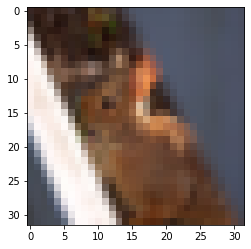

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

index = random.randint(0, len(trainset_x))
plt.figure()
plt.imshow(trainset_x[index])
print(trainset_y[index])
print(meta[b'coarse_label_names'][trainset_y[index]])

设计网络

In [22]:
import os
import cv2
import numpy as np
import shutil
from PIL import Image
import sys

current_num = 0

def CLAHE(img):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img)
    return cl1

def Histograms_Equalization(img):
    equ = cv2.equalizeHist(img)
    return equ

def make_one_hot(data, num):
    return (np.arange(num)==data[:,None]).astype(np.integer)

In [23]:
from sklearn.utils import shuffle

new_X_train = []
new_y_train = []
for index in range(len(trainset_x)):
    sys.stdout.write(" {} / {}\r".format(index, len(trainset_x)))

    img_gray = cv2.cvtColor(trainset_x[index], cv2.COLOR_RGB2GRAY)

    new_X_train.append(img_gray.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    he_image = Histograms_Equalization(img_gray)
    new_X_train.append(he_image.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    clahe_img = CLAHE(img_gray)
    new_X_train.append(clahe_img.astype('float32') / 255.0)
    new_y_train.append(trainset_y[index])
    
    
print("All done!")
all_xs = np.expand_dims(new_X_train, 3)
all_ys = make_one_hot(np.array(new_y_train), n_class)
train_xs, valid_xs, train_ys, valid_ys = train_test_split(
    all_xs, all_ys, test_size=0.2, random_state=0)
# all_xs, all_ys = shuffle(np.array(new_X_train), np.array(new_y_train), random_state=0)

pickle.dump(all_xs, open('all_xs.p', 'wb'))
pickle.dump(all_ys, open('all_ys.p', 'wb'))

All done!50000


<ipython-input-22-7f6693f09a0e>:20: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  return (np.arange(num)==data[:,None]).astype(np.integer)


有个warning，但不影响程序

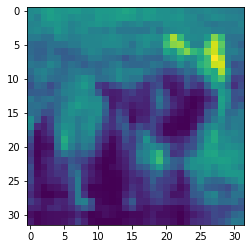

In [26]:
#index = 17245 
#index = 12457 、
index = 23456
img_gray = cv2.cvtColor(trainset_x[index], cv2.COLOR_RGB2GRAY)
plt.figure()
plt.imshow(img_gray)

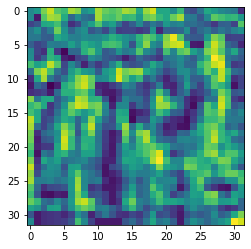

In [29]:
#index = 17245 
#index = 12457
index = 23456
img_gray = cv2.cvtColor(trainset_x[index], cv2.COLOR_RGB2GRAY)
# img_gray = Histograms_Equalization(img_gray)
img_gray = CLAHE(img_gray)
plt.figure()
plt.imshow(img_gray)

处理测试集

In [30]:
from sklearn.utils import shuffle

test_set = []
for j in range(len(testset_x)):
    img_gray = cv2.cvtColor(testset_x[j], cv2.COLOR_RGB2GRAY)
#     img_gray = Histograms_Equalization(img_gray)
    img_gray = np.expand_dims(img_gray, 2)
    img_gray = img_gray / 255.0
    test_set.append(img_gray)

test_set = np.array(test_set)
y_test = make_one_hot(np.array(testset_y), n_class)

def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]

<ipython-input-22-7f6693f09a0e>:20: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.
  return (np.arange(num)==data[:,None]).astype(np.integer)


这里先是用tensorflow的1代，2代里面有几个函数被删除了，后面会根据TensorFlow2的特性再设计一个网络

In [44]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import datetime

class network(object):
    def __init__(self):

        self.graph = tf.Graph()
        with self.graph.as_default():
            self.x = tf.placeholder(tf.float32, shape=[None, 32, 32, 1], name='input_tensor')
            self.y = tf.placeholder(tf.float32, shape=[None, n_class], name='labels')
            
            conv1 = tf.layers.conv2d(self.x, filters=100, kernel_size=5, activation=tf.nn.relu)            
            print("conv1.shape = ", conv1.get_shape())  # (_, 28, 28, 100)    
            self.conv1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)

            conv2 = tf.layers.conv2d(self.conv1, filters=150, kernel_size=3, activation=tf.nn.relu)            
            print("conv2.shape = ", conv2.get_shape())  # (_, 12, 12, 150)     
            self.conv2 = tf.layers.max_pooling2d(conv2, pool_size=2, strides=2)
            print("max_pool conv2.shape = ", self.conv2.get_shape())  # (?, 6, 6, 150)  

            conv3 = tf.layers.conv2d(self.conv2, filters=250, kernel_size=3, padding='same', activation=tf.nn.relu)            
            print("conv3.shape = ", conv3.get_shape())  # (_, 6, 6, 250)  
            self.conv3 = tf.layers.max_pooling2d(conv3, pool_size=2, strides=2)
            print("max_pool conv3.shape = ", self.conv3.get_shape())  # (_, 3, 3, 250)  

            self.fc0   = tf.layers.flatten(self.conv3)
            print("fc0.shape = ", self.fc0.get_shape())  # (_, 2250)  

            self.fc1 = tf.layers.dense(self.fc0, units=512, activation=tf.nn.relu)

            self.fc2 = tf.layers.dense(self.fc1, units=300, activation=tf.nn.relu)
            
            self.logits = tf.layers.dense(self.fc2, units=n_class)

            with tf.name_scope('loss'):
                self.cross_entropy = tf.reduce_mean(
                    tf.losses.softmax_cross_entropy(self.y, logits=self.logits))

            with tf.name_scope('train_step'):
                self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.cross_entropy)

            with tf.name_scope('accuracy'):
                correct_prediction = tf.equal(tf.argmax(self.logits,1), tf.argmax(self.y,1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            self.saver = tf.train.Saver()
            self.sess = tf.Session(graph=self.graph)
            self.sess.run(tf.global_variables_initializer())

            self.save_dir = './session'
            if not os.path.isdir(self.save_dir):
                os.mkdir(self.save_dir)
            self.ckpt = tf.train.get_checkpoint_state(self.save_dir)
            if self.ckpt and self.ckpt.model_checkpoint_path:
                self.saver.restore(self.sess, tf.train.latest_checkpoint(self.save_dir))
                print("Successfully loaded:", tf.train.latest_checkpoint(self.save_dir))
            else:
                print("Could not find old network weights")

    def training(self, xs, labels, ii, epoch_i, batch_i, batch_num):
        feed_dict = {
            self.x: xs,
            self.y: labels
        }

        _, accuracy, loss = self.sess.run([self.train_step, self.accuracy, self.cross_entropy], feed_dict=feed_dict)
        if (ii % 20 == 0):
            time_str = datetime.datetime.now().isoformat()
            print('Training {}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.5f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    batch_num,
                    loss))

        return accuracy, loss
    
    def testing(self, xs, labels, ii, epoch_i, batch_i, batch_num):
        feed_dict = {
            self.x: xs,
            self.y: labels
        }

        accuracy, loss = self.sess.run([self.accuracy, self.cross_entropy], feed_dict=feed_dict)
        if (ii % 20 == 0):
            time_str = datetime.datetime.now().isoformat()
            print('#Testing# {}: Epoch {:>3} Batch {:>4}/{} accuracy = {:.3f}  test_loss = {:.5f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    batch_num,
                    accuracy,
                    loss))

        return accuracy, loss
            
    def save(self):
        save_path = self.saver.save(self.sess, os.path.join(self.save_dir, 'best_model.ckpt'))    
        print("Model saved in file: {}".format(save_path))
        
    def forward(self, xs):  
        feed_dict = {
            self.x: xs
        }
        logits = self.sess.run([tf.nn.softmax(self.logits)], feed_dict=feed_dict)
        logits = np.reshape(np.array(logits), (n_classes))

        return logits

开始训练

In [45]:
epochs = 5
net = network()
total_batch_size = 64

best_loss = 999

for ii in range(epochs):
    train_batches = get_batches(train_xs, train_ys, total_batch_size)
    test_batches = get_batches(valid_xs, valid_ys, total_batch_size)
    batch_num = (len(train_xs) // total_batch_size)
    for batch_i in range(batch_num):
        x, y = next(train_batches)
        net.training(x, y, ii * (batch_num) + batch_i, ii, batch_i, batch_num)
        
    batch_num = (len(valid_xs) // total_batch_size)
    test_loss = 0.0
    test_acc = 0.0
    for batch_i  in range(batch_num):
        x, y = next(test_batches)
        acc, loss = net.testing(x, y, ii * (batch_num) + batch_i, ii, batch_i, batch_num)
        test_loss = test_loss + loss
        test_acc = test_acc + acc
        
    test_acc = test_acc / batch_num
    test_loss = test_loss / batch_num
    if test_loss < best_loss:
        best_loss = test_loss
        print("best loss = {}  acc = {}".format(best_loss, test_acc))
        net.save()
    else:
        print("test loss = {}  acc = {}".format(test_loss, test_acc))


<ipython-input-44-4234775e7210>:13: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.layers.conv2d(self.x, filters=100, kernel_size=5, activation=tf.nn.relu)
<ipython-input-44-4234775e7210>:15: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  self.conv1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)
<ipython-input-44-4234775e7210>:17: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.layers.conv2d(self.conv1, filters=150, kernel_size=3, activation=tf.nn.relu)
<ipython-input-44-4234775e7210>:19: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  self.conv2 = tf.layers.max_pooling2d(conv2, pool_size=

conv1.shape =  (?, 28, 28, 100)
conv2.shape =  (?, 12, 12, 150)
max_pool conv2.shape =  (?, 6, 6, 150)
conv3.shape =  (?, 6, 6, 250)
max_pool conv3.shape =  (?, 3, 3, 250)
fc0.shape =  (?, 2250)
INFO:tensorflow:Restoring parameters from ./session\best_model.ckpt
Successfully loaded: ./session\best_model.ckpt
Training 2022-02-21T16:39:37.737976: Epoch   0 Batch    0/1875   train_loss = 2.18888
Training 2022-02-21T16:39:40.277417: Epoch   0 Batch   20/1875   train_loss = 2.35947
Training 2022-02-21T16:39:42.591483: Epoch   0 Batch   40/1875   train_loss = 1.95382
Training 2022-02-21T16:39:45.200070: Epoch   0 Batch   60/1875   train_loss = 2.05660
Training 2022-02-21T16:39:48.219413: Epoch   0 Batch   80/1875   train_loss = 2.07522
Training 2022-02-21T16:39:50.849920: Epoch   0 Batch  100/1875   train_loss = 2.01661
Training 2022-02-21T16:39:53.935499: Epoch   0 Batch  120/1875   train_loss = 1.98994
Training 2022-02-21T16:39:56.411752: Epoch   0 Batch  140/1875   train_loss = 1.95196
Tr

Training 2022-02-21T16:43:56.202370: Epoch   0 Batch 1840/1875   train_loss = 1.87058
Training 2022-02-21T16:43:58.721632: Epoch   0 Batch 1860/1875   train_loss = 2.01757
#Testing# 2022-02-21T16:44:00.525810: Epoch   0 Batch    0/468 accuracy = 0.484  test_loss = 1.67643
#Testing# 2022-02-21T16:44:01.038439: Epoch   0 Batch   20/468 accuracy = 0.375  test_loss = 1.86075
#Testing# 2022-02-21T16:44:01.531122: Epoch   0 Batch   40/468 accuracy = 0.344  test_loss = 1.99714
#Testing# 2022-02-21T16:44:02.023807: Epoch   0 Batch   60/468 accuracy = 0.359  test_loss = 2.18973
#Testing# 2022-02-21T16:44:02.493551: Epoch   0 Batch   80/468 accuracy = 0.469  test_loss = 1.74681
#Testing# 2022-02-21T16:44:02.996206: Epoch   0 Batch  100/468 accuracy = 0.453  test_loss = 1.93121
#Testing# 2022-02-21T16:44:03.595604: Epoch   0 Batch  120/468 accuracy = 0.312  test_loss = 2.02127
#Testing# 2022-02-21T16:44:04.052386: Epoch   0 Batch  140/468 accuracy = 0.344  test_loss = 1.99814
#Testing# 2022-02-21

Training 2022-02-21T16:46:43.939332: Epoch   1 Batch 1285/1875   train_loss = 2.15779
Training 2022-02-21T16:46:46.133467: Epoch   1 Batch 1305/1875   train_loss = 1.71196
Training 2022-02-21T16:46:48.407576: Epoch   1 Batch 1325/1875   train_loss = 1.68145
Training 2022-02-21T16:46:50.745002: Epoch   1 Batch 1345/1875   train_loss = 1.63610
Training 2022-02-21T16:46:53.141637: Epoch   1 Batch 1365/1875   train_loss = 2.04071
Training 2022-02-21T16:46:55.828472: Epoch   1 Batch 1385/1875   train_loss = 1.66923
Training 2022-02-21T16:46:58.020621: Epoch   1 Batch 1405/1875   train_loss = 1.92650
Training 2022-02-21T16:47:01.091412: Epoch   1 Batch 1425/1875   train_loss = 1.67436
Training 2022-02-21T16:47:03.855027: Epoch   1 Batch 1445/1875   train_loss = 1.91139
Training 2022-02-21T16:47:06.311464: Epoch   1 Batch 1465/1875   train_loss = 1.89961
Training 2022-02-21T16:47:09.400115: Epoch   1 Batch 1485/1875   train_loss = 1.55014
Training 2022-02-21T16:47:12.383192: Epoch   1 Batch 1

Training 2022-02-21T16:49:46.993692: Epoch   2 Batch  770/1875   train_loss = 1.56472
Training 2022-02-21T16:49:49.291607: Epoch   2 Batch  790/1875   train_loss = 1.71612
Training 2022-02-21T16:49:51.966843: Epoch   2 Batch  810/1875   train_loss = 1.62686
Training 2022-02-21T16:49:54.630957: Epoch   2 Batch  830/1875   train_loss = 1.98031
Training 2022-02-21T16:49:57.079413: Epoch   2 Batch  850/1875   train_loss = 1.64834
Training 2022-02-21T16:49:59.831058: Epoch   2 Batch  870/1875   train_loss = 1.63927
Training 2022-02-21T16:50:03.027526: Epoch   2 Batch  890/1875   train_loss = 1.63158
Training 2022-02-21T16:50:05.834020: Epoch   2 Batch  910/1875   train_loss = 1.59206
Training 2022-02-21T16:50:08.636527: Epoch   2 Batch  930/1875   train_loss = 1.60953
Training 2022-02-21T16:50:11.214637: Epoch   2 Batch  950/1875   train_loss = 1.72858
Training 2022-02-21T16:50:13.560366: Epoch   2 Batch  970/1875   train_loss = 1.67984
Training 2022-02-21T16:50:16.480560: Epoch   2 Batch  

Training 2022-02-21T16:52:57.295575: Epoch   3 Batch  215/1875   train_loss = 1.71307
Training 2022-02-21T16:52:59.464218: Epoch   3 Batch  235/1875   train_loss = 1.71808
Training 2022-02-21T16:53:01.647928: Epoch   3 Batch  255/1875   train_loss = 1.55396
Training 2022-02-21T16:53:03.779729: Epoch   3 Batch  275/1875   train_loss = 1.88363
Training 2022-02-21T16:53:05.820737: Epoch   3 Batch  295/1875   train_loss = 1.77346
Training 2022-02-21T16:53:07.901065: Epoch   3 Batch  315/1875   train_loss = 2.04089
Training 2022-02-21T16:53:10.505733: Epoch   3 Batch  335/1875   train_loss = 1.40364
Training 2022-02-21T16:53:13.172918: Epoch   3 Batch  355/1875   train_loss = 1.44911
Training 2022-02-21T16:53:15.852953: Epoch   3 Batch  375/1875   train_loss = 1.59013
Training 2022-02-21T16:53:19.206040: Epoch   3 Batch  395/1875   train_loss = 1.72672
Training 2022-02-21T16:53:21.703504: Epoch   3 Batch  415/1875   train_loss = 1.72485
Training 2022-02-21T16:53:24.053226: Epoch   3 Batch  

#Testing# 2022-02-21T16:56:23.780061: Epoch   3 Batch  236/468 accuracy = 0.484  test_loss = 1.75687
#Testing# 2022-02-21T16:56:24.303665: Epoch   3 Batch  256/468 accuracy = 0.484  test_loss = 1.75439
#Testing# 2022-02-21T16:56:24.827270: Epoch   3 Batch  276/468 accuracy = 0.484  test_loss = 1.81230
#Testing# 2022-02-21T16:56:25.321941: Epoch   3 Batch  296/468 accuracy = 0.375  test_loss = 1.83816
#Testing# 2022-02-21T16:56:25.867482: Epoch   3 Batch  316/468 accuracy = 0.484  test_loss = 1.69411
#Testing# 2022-02-21T16:56:26.417014: Epoch   3 Batch  336/468 accuracy = 0.500  test_loss = 1.67010
#Testing# 2022-02-21T16:56:26.943606: Epoch   3 Batch  356/468 accuracy = 0.453  test_loss = 1.68927
#Testing# 2022-02-21T16:56:27.447261: Epoch   3 Batch  376/468 accuracy = 0.438  test_loss = 1.75854
#Testing# 2022-02-21T16:56:27.953907: Epoch   3 Batch  396/468 accuracy = 0.484  test_loss = 1.77565
#Testing# 2022-02-21T16:56:28.457559: Epoch   3 Batch  416/468 accuracy = 0.422  test_loss 

Training 2022-02-21T16:59:36.944023: Epoch   4 Batch 1600/1875   train_loss = 1.64843
Training 2022-02-21T16:59:39.204593: Epoch   4 Batch 1620/1875   train_loss = 1.74308
Training 2022-02-21T16:59:41.297647: Epoch   4 Batch 1640/1875   train_loss = 0.99920
Training 2022-02-21T16:59:43.407696: Epoch   4 Batch 1660/1875   train_loss = 1.21198
Training 2022-02-21T16:59:45.452662: Epoch   4 Batch 1680/1875   train_loss = 1.34291
Training 2022-02-21T16:59:47.495236: Epoch   4 Batch 1700/1875   train_loss = 1.12393
Training 2022-02-21T16:59:49.525898: Epoch   4 Batch 1720/1875   train_loss = 1.56592
Training 2022-02-21T16:59:51.917469: Epoch   4 Batch 1740/1875   train_loss = 1.39323
Training 2022-02-21T16:59:54.324812: Epoch   4 Batch 1760/1875   train_loss = 1.33199
Training 2022-02-21T16:59:57.086436: Epoch   4 Batch 1780/1875   train_loss = 1.62660
Training 2022-02-21T16:59:59.250776: Epoch   4 Batch 1800/1875   train_loss = 1.46429
Training 2022-02-21T17:00:01.622177: Epoch   4 Batch 1

测试集

In [47]:
net = network()

test_batches = get_batches(test_set, y_test, total_batch_size)
batch_num = (len(test_set) // total_batch_size)
test_loss = 0.0
test_acc = 0.0
for batch_i  in range(batch_num):
    x, y = next(test_batches)
    acc, loss = net.testing(x, y, 0 * (batch_num) + batch_i, 0, batch_i, batch_num)
    test_loss = test_loss + loss
    test_acc = test_acc + acc
        
test_acc = test_acc / batch_num
test_loss = test_loss / batch_num
print("test loss = {}  acc = {}".format(test_loss, test_acc))

<ipython-input-44-4234775e7210>:13: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.layers.conv2d(self.x, filters=100, kernel_size=5, activation=tf.nn.relu)
<ipython-input-44-4234775e7210>:15: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  self.conv1 = tf.layers.max_pooling2d(conv1, pool_size=2, strides=2)
<ipython-input-44-4234775e7210>:17: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.layers.conv2d(self.conv1, filters=150, kernel_size=3, activation=tf.nn.relu)
<ipython-input-44-4234775e7210>:19: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  self.conv2 = tf.layers.max_pooling2d(conv2, pool_size=

conv1.shape =  (?, 28, 28, 100)
conv2.shape =  (?, 12, 12, 150)
max_pool conv2.shape =  (?, 6, 6, 150)
conv3.shape =  (?, 6, 6, 250)
max_pool conv3.shape =  (?, 3, 3, 250)
fc0.shape =  (?, 2250)
INFO:tensorflow:Restoring parameters from ./session\best_model.ckpt
Successfully loaded: ./session\best_model.ckpt
#Testing# 2022-02-21T17:00:52.797417: Epoch   0 Batch    0/156 accuracy = 0.531  test_loss = 1.76817
#Testing# 2022-02-21T17:00:53.534451: Epoch   0 Batch   20/156 accuracy = 0.406  test_loss = 1.88650
#Testing# 2022-02-21T17:00:54.134842: Epoch   0 Batch   40/156 accuracy = 0.469  test_loss = 1.87414
#Testing# 2022-02-21T17:00:54.667419: Epoch   0 Batch   60/156 accuracy = 0.344  test_loss = 1.99367
#Testing# 2022-02-21T17:00:55.197003: Epoch   0 Batch   80/156 accuracy = 0.469  test_loss = 1.90319
#Testing# 2022-02-21T17:00:55.704646: Epoch   0 Batch  100/156 accuracy = 0.391  test_loss = 2.07405
#Testing# 2022-02-21T17:00:56.215282: Epoch   0 Batch  120/156 accuracy = 0.469  tes

以下为TensorFlow2的网络设计和训练测试，数据集没有改变

In [48]:
from tensorflow import keras
import tensorflow as tf
import datetime
from tensorflow.python.ops import summary_ops_v2

In [51]:
# 网络一开始的InputLayer可以使用这句代码代替： keras.layers.Reshape(target_shape=[32, 32, 1], input_shape=(32, 32,)),

# 另外， InputLayer也可以省略，这样的话， 需要在Conv2D中指定输入的形状，网络前两层（InputLayer和Conv2D）可以用这句代码代替：
# keras.layers.Conv2D (kernel_size = (5, 5), filters = 100, activation='relu', input_shape=(32, 32, 1)),

# 注意， InputLayer并不是网络的第一层， 只是用来说明输入的尺寸
def get_model():
    model = keras.Sequential([
            keras.layers.InputLayer(input_shape=(32, 32, 1)),
            keras.layers.Conv2D (kernel_size = (5, 5), filters = 100, activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D (kernel_size = (3, 3), filters = 150, activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Conv2D (kernel_size = (3, 3), filters = 250, padding='same', activation='relu'),
            keras.layers.MaxPool2D(),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation='relu'),
            keras.layers.Dense(300, activation='relu'),
            keras.layers.Dense(n_class, activation='softmax')
        ])
    return model

model = get_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 100)       2600      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 100)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 150)       135150    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 150)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 250)         337750    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 250)       

In [53]:
checkpoint_path = "training_models/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True,
    # Save weights, every 1-epochs.
    period=1)

callbacks = [
    cp_callback,
    # Interrupt training if `val_loss` stops improving for over 2 epochs
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    # Write TensorBoard logs to `./logs` directory
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]
#warning无所谓的

In [54]:
# 开始训练
model.save_weights(checkpoint_path.format(epoch=0))
model.fit(train_xs, train_ys, epochs=5, batch_size=64, validation_data=(valid_xs, valid_ys), 
          callbacks=callbacks) # validation_split=0.2

Train on 120000 samples, validate on 30000 samples
Epoch 1/5
120000/120000 [==============================] - ETA: 0s - loss: 2.6732 - acc: 0.1840

C:\Users\lxpperfect\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 2.42907, saving model to training_models\cp-0001.ckpt
120000/120000 [==============================] - 260s 2ms/sample - loss: 2.6732 - acc: 0.1840 - val_loss: 2.4291 - val_acc: 0.2573
Epoch 2/5
120000/120000 [==============================] - ETA: 0s - loss: 2.3263 - acc: 0.2907
Epoch 2: val_loss improved from 2.42907 to 2.28520, saving model to training_models\cp-0002.ckpt
120000/120000 [==============================] - 246s 2ms/sample - loss: 2.3263 - acc: 0.2907 - val_loss: 2.2852 - val_acc: 0.2997
Epoch 3/5
120000/120000 [==============================] - ETA: 0s - loss: 2.1305 - acc: 0.3502
Epoch 3: val_loss improved from 2.28520 to 2.08420, saving model to training_models\cp-0003.ckpt
120000/120000 [==============================] - 259s 2ms/sample - loss: 2.1305 - acc: 0.3502 - val_loss: 2.0842 - val_acc: 0.3594
Epoch 4/5
120000/120000 [==============================] - ETA: 0s - loss: 1.9737 - acc: 0.3979
Epoch 4: val_loss improved from

In [55]:
test_loss, test_acc = model.evaluate(test_set, y_test)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.3989


可以加载保存的参数继续训练

In [56]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

model = get_model()

model.load_weights(latest)

# The re-loaded model needs to be re-compiled.
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_xs, train_ys, epochs=1, batch_size=64, validation_data=(valid_xs, valid_ys), 
          callbacks=callbacks) 

Train on 120000 samples, validate on 30000 samples
120000/120000 [==============================] - ETA: 0s - loss: 1.7265 - acc: 0.4693
Epoch 1: val_loss improved from 1.88206 to 1.80626, saving model to training_models\cp-0001.ckpt
120000/120000 [==============================] - 232s 2ms/sample - loss: 1.7265 - acc: 0.4693 - val_loss: 1.8063 - val_acc: 0.4473


In [57]:
test_loss, test_acc = model.evaluate(test_set, y_test)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.4134
